# Setting up

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import datasets, tree
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.random import set_seed

# Import data
from preprocessing import load_diabetes_prepr

# Interpretability measures
from interpretability import PDP

import shap

In [2]:
def find_best_model(model, parameters, X_train, y_train): 
    clf = GridSearchCV(model, parameters, scoring=('neg_root_mean_squared_error'), cv=KFold())
    clf.fit(X_train, y_train)

    return clf

def print_errors(model, model_name, X_test, y_test):
    y_pred = model.predict(X_test)
    
    if model_name == "Neural network":
        y_pred = np.reshape(y_pred, len(y_test))
    
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print("RMSE ({}): {}".format(model_name, rmse))
    r2 = r2_score(y_test, y_pred)
    print("R-squared score ({}) : {}".format(model_name, r2))

In [3]:
X, y, feature_names = load_diabetes_prepr()
seed = 3012

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Training models

## Sci-kit learn models

In [4]:
model_names = [
    "decision tree regressor",
    "linear regression",
    "k-nearest neighbors",
    ]

parameters = {
    "decision tree regressor": {'criterion': ('squared_error', 'friedman_mse', 'absolute_error', 'poisson'), 'splitter': ('best', 'random') , 'min_samples_split': np.arange(2, 20)},
    "linear regression": {},
    "k-nearest neighbors": {'n_neighbors': np.arange(1, 20), 'weights': ('uniform', 'distance')},
    }

models_init = {
    "decision tree regressor": tree.DecisionTreeRegressor(random_state=seed),
    "linear regression": LinearRegression(),
    "k-nearest neighbors": KNeighborsRegressor(),
    }

models = dict()

for model_name in model_names:
    clf = find_best_model(models_init[model_name], parameters[model_name], X_train, y_train)
    models[model_name] = clf.best_estimator_

## Neural network

In [ ]:
X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.2, random_state=seed)

In [ ]:
# Initialise neural network
BATCH_SIZE=64
INPUT_SIZE= X_train.shape[1]

set_seed(seed)

model = Sequential()
model.add(Input(INPUT_SIZE))
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.1))
# model.add(Dense(10, activation="relu"))
# model.add(Dropout(0.1))
model.add(Dense(10, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(optimizer='adam',
                loss="mean_absolute_error",
                metrics=['mean_squared_error'])

n_epochs = 300
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=n_epochs, validation_data=(X_val, y_val)) # validation_split=0.2)

models["neural network"] = model

Epoch 1/300
5/5 [==============================] - 1s 197ms/step - loss: 146.4270 - mean_squared_error: 27086.4674 - val_loss: 140.8831 - val_mean_squared_error: 25423.3105
Epoch 2/300
5/5 [==============================] - 0s 12ms/step - loss: 147.9914 - mean_squared_error: 27120.5641 - val_loss: 140.7796 - val_mean_squared_error: 25395.7246
Epoch 3/300
5/5 [==============================] - 0s 12ms/step - loss: 146.4534 - mean_squared_error: 26560.8151 - val_loss: 140.6728 - val_mean_squared_error: 25367.3555
Epoch 4/300
5/5 [==============================] - 0s 12ms/step - loss: 152.5552 - mean_squared_error: 28749.9326 - val_loss: 140.5561 - val_mean_squared_error: 25335.6348
Epoch 5/300
5/5 [==============================] - 0s 12ms/step - loss: 148.6716 - mean_squared_error: 27654.7334 - val_loss: 140.4284 - val_mean_squared_error: 25301.2031
Epoch 6/300
5/5 [==============================] - 0s 12ms/step - loss: 146.2454 - mean_squared_error: 26251.7858 - val_loss: 140.2891 - va

## Errors

In [5]:
for model_name in models.keys():
    print_errors(models[model_name], model_name, X_test, y_test)

RMSE (decision tree regressor): 69.59748588943553
R-squared score (decision tree regressor) : 0.3640695526393021
RMSE (linear regression): 58.94293390689424
R-squared score (linear regression) : 0.543872754881746
RMSE (k-nearest neighbors): 64.45688846172169
R-squared score (k-nearest neighbors) : 0.4545421586812478


# Intrinsic interpretability

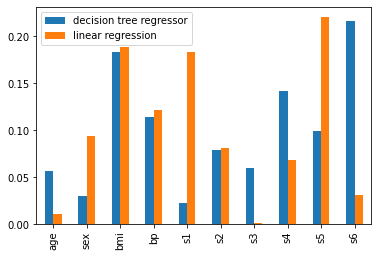

In [ ]:
dtr_feat_imps = models["decision tree regressor"].feature_importances_

linreg_coefs = models["linear regression"].coef_
linreg_feat_imps = np.abs(linreg_coefs) / np.sum(np.abs(linreg_coefs))

feat_imps = pd.DataFrame({"decision tree regressor": dtr_feat_imps, "linear regression": linreg_feat_imps}, index=feature_names)
feat_imps.plot.bar()
plt.show()

# Partial dependence plot

In [ ]:
categorical = [False, True, False, False, False, False, False, False, False, False]

for model_name in models.keys():
    model = models[model_name]
    print(model_name)

    for i in range(3): # range(X_test.shape[1]):
        PDP(i, feature_names[i], model, X_test, y_test, categorical=categorical[i])
        plt.show()
        plt.close()

# SHAP

## Instance-based interpretation

In [ ]:
models["neural network"].predict(X_test[:2])

array([[197.7348 ],
       [ 96.16026]], dtype=float32)

In [ ]:
explainers = dict()

for model_name in models.keys():
  model = models[model_name]

  if model_name == "neural network":
    def nn_predict(X):
      y_pred = model.predict(X)
      y_pred = np.reshape(y_pred, X.shape[0])
      return y_pred

    explainers[model_name] = shap.KernelExplainer(nn_predict, X_train)
  else:
    explainers[model_name] = shap.KernelExplainer(model.predict, X_train)

Using 282 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 282 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 282 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 282 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


<BarContainer object of 10 artists>

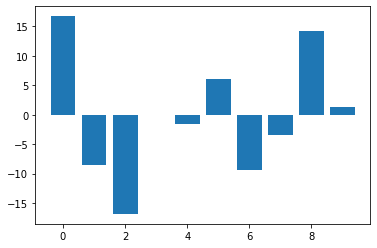

In [ ]:
idx = 4
model_name = "neural network"

X_test_df = pd.DataFrame(X_test, columns=feature_names)

explainer = explainers[model_name]
shap_test = explainer.shap_values(X_test_df.iloc[idx])

# PLOT SHAPLEY VALUES IN NORMAL WAY

plt.bar(np.arange(len(feature_names)), shap_test)

# shap.initjs()
# shap.force_plot(explainer.expected_value, shap_test, X_test_df.iloc[idx])

## Global interpretation

In [ ]:
shap_values_all = dict()
X_test_df = pd.DataFrame(X_test, columns=feature_names)

for model_name in models.keys():
    print(model_name)
    explainer = explainers[model_name]

    shap_values = explainer.shap_values(X_test_df.iloc[:7])
    shap_values_all[model_name] = shap_values

decision tree regressor


  0%|          | 0/7 [00:00<?, ?it/s]

linear regression


  0%|          | 0/7 [00:00<?, ?it/s]

k-nearest neighbors


  0%|          | 0/7 [00:00<?, ?it/s]

neural network


  0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
shapley_feat_imps = pd.DataFrame(index=feature_names)

for model_name in models.keys():
  shap_values = shap_values_all[model_name]
  feat_imps = np.mean(np.abs(shap_values), axis=0)
  feat_imps /= np.sum(feat_imps)
  shapley_feat_imps.insert(0, model_name, feat_imps)

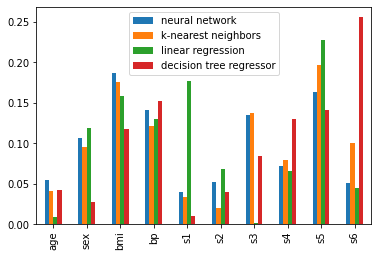

In [ ]:
shapley_feat_imps.plot.bar()
plt.show()

# Counterfactuals

In [6]:
categorical = [False, True, False, False, False, False, False, False, False, False] # meegeven bij preprocessing module
categorical_values = list()

for i in range(len(feature_names)):
  if categorical[i]:
    categorical_values.append(np.unique(X_train[:, i]))
  else:
    categorical_values.append(None)

In [7]:
def postproces_nn(y_pred_nn):
  return np.reshape(y_pred_nn, y_pred_nn.shape[0])

In [10]:
print(model.predict(X_test))

[213.94006129 100.35461183 122.16133058 179.34727178 129.10358991
  80.74110797  99.99157389 212.6901091  196.83151573 100.88297703
 235.88384761 163.6078187   95.94159925 102.83230327  93.82090132
 124.46788423 146.85834065 144.44500219 134.17486577 211.13983663
 172.08890219 163.97225735 202.56083849 120.78415226 143.43128374
 228.89230304 117.96205498 254.63532797  50.85889278 123.33236078
 108.84425003 209.0830146  153.44954168  85.90091572 147.83237593
 281.14773569  70.99984287 106.66175049 230.16964391 220.49281315
 114.3400661  150.53826906 154.71762008  99.10684691 236.96850735
 118.16720995 110.25178335  60.76732173 134.30243832 227.29046351
  67.51578801 184.21706593 143.79948683 130.51489768 171.73493777
 235.05741856 206.16660359 150.51035358 136.35650993 225.81601465
 202.53719899 207.27382307 185.46578733 256.66968436 174.66469766
 142.7184409  176.49708969 166.59824806 261.66380458 137.52044732
 114.07163319 201.98969536 107.06816664 142.51406961 207.25806532
 202.21869

In [16]:
instance_idx = 0
n_counterfactuals = 10
update_time = 5000
model_name = "decision tree regressor" 
# features_to_vary = categorical
features_to_vary = [True] * len(feature_names)
# features_to_vary = [True, True, True, True, False, False, False, False, False, False]
limit_varied_features = True
goal_pred = 70.0
alpha = 1.0
tol = 2.0

model = models[model_name]

np.random.seed(seed)

instance = X_test[instance_idx]
instance = np.reshape(instance, (1, len(feature_names)))
original_pred = model.predict(instance)[0]
print(f"Original prediction: {original_pred}")

counterfactuals = instance * np.ones((n_counterfactuals, len(feature_names)))
counterfactual_losses = np.ones(n_counterfactuals) * 100

update_counter = 0
total_counter = 0

while update_counter < update_time:
  counterfactual_found = False
  counter = 0
  prev_instance = np.copy(instance)

  while counter < 100 and not counterfactual_found:
    # Change a feature value randomly
    feature_idx = np.random.randint(len(feature_names))

    while not features_to_vary[feature_idx]:
      feature_idx = np.random.randint(len(feature_names))

    if categorical[feature_idx]:
      new_value = np.random.choice(categorical_values[feature_idx])
    else:
      minimum_value = np.min(X_train[:,feature_idx]) # extend this range
      maximum_value = np.max(X_train[:,feature_idx])
      new_value = np.random.random() * (maximum_value - minimum_value) + minimum_value
    
    new_instance = np.copy(prev_instance)
    new_instance[:,feature_idx] = new_value

    # Make a new prediction
    new_pred = model.predict(new_instance)[0]
    
    # Check if new instance is a counterfactual
    if new_pred > goal_pred - tol and new_pred < goal_pred + tol:
      counterfactual_found = True
      counterfactual_loss = np.sum(np.abs(new_instance - instance)) + alpha * np.abs(new_pred - goal_pred)

      # Check if counterfactual already in the set
      # not (new_instance == counterfactuals).all(axis=1).any()

      # Standard counterfactual to replace is the one with the biggest loss value
      idx_to_replace = np.argmax(counterfactual_losses)

      # If varied features are limited we replace the instance with the same
      # varied features
      if limit_varied_features:
        counterfactuals_varied_features = ((counterfactuals - instance) != 0.0)
        varied_features = ((new_instance - instance) != 0.0)
      
        counterfactuals_with_same_varied_features = (varied_features == counterfactuals_varied_features).all(axis=1)

        if counterfactuals_with_same_varied_features.any():
          idx_to_replace = np.where(counterfactuals_with_same_varied_features)
      
      # Check if new loss value is smaller than the one we want to replace
      if counterfactual_loss < counterfactual_losses[idx_to_replace]:
        # Replace counterfactual in set with found instance
        counterfactuals[idx_to_replace] = new_instance
        counterfactual_losses[idx_to_replace] = counterfactual_loss
        
        print("---------------------------------------------------------------")
        print(f"Counts total: {total_counter}")
        print(f"Counts since last update: {update_counter}")
        print(f"Counterfactual losses: {counterfactual_losses}")

        update_counter = 0
    
    prev_instance = np.copy(new_instance)

    counter += 1
    
  update_counter += 1
  total_counter += 1

print("---------------------------------------------------------------")
print(f"Total counts: {total_counter}")
print(f"Counts since last update: {update_counter}")

sort_indices = np.argsort(counterfactual_losses)
counterfactual_losses = counterfactual_losses[sort_indices]
counterfactuals = counterfactuals[sort_indices]

# Niet counterfactuals eruit halen eventueel

print(f"Counterfactual_losses: {counterfactual_losses}")

Original prediction: 211.3
---------------------------------------------------------------
Counts total: 9
Counts since last update: 9
Counterfactual losses: [ 16.03380867 100.         100.         100.         100.
 100.         100.         100.         100.         100.        ]
---------------------------------------------------------------
Counts total: 69
Counts since last update: 60
Counterfactual losses: [ 16.03380867  17.05669266 100.         100.         100.
 100.         100.         100.         100.         100.        ]
---------------------------------------------------------------
Counts total: 437
Counts since last update: 368
Counterfactual losses: [ 16.03380867  15.43966731 100.         100.         100.
 100.         100.         100.         100.         100.        ]
---------------------------------------------------------------
Counts total: 579
Counts since last update: 142
Counterfactual losses: [ 14.53946325  15.43966731 100.         100.         100.
 100. 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=90a57419-7b7b-4aa4-8a97-858f9f98a849' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>